<a href="https://colab.research.google.com/github/bobbyknit007/ML/blob/main/Regression/Uber_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from warnings import filterwarnings
filterwarnings('ignore')
from datetime import datetime
from math import radians, sin, cos, acos

In [123]:
df =pd.read_csv('/content/uber.csv')
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


Column unnamed, key looks wrong data- **remove them**
Pickup_datetime - Date is not so important may be Day of week and Time in HH:MM would be helpful
Latitude and Longitude - we need to convert it to distance

In [124]:
df.drop(['Unnamed: 0','key'], axis=1, inplace=True)

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        200000 non-null  float64
 1   pickup_datetime    200000 non-null  object 
 2   pickup_longitude   200000 non-null  float64
 3   pickup_latitude    200000 non-null  float64
 4   dropoff_longitude  199999 non-null  float64
 5   dropoff_latitude   199999 non-null  float64
 6   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 10.7+ MB


In [126]:
df.isnull().sum()

,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,1
dropoff_latitude,1
passenger_count,0


In [127]:
df.isna().sum()

,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,1
dropoff_latitude,1
passenger_count,0


In [128]:
df.shape

(200000, 7)

In [129]:
df.dropna(axis=0, inplace=True)

In [130]:
df.shape

(199999, 7)

In [131]:

def getDateTime(datetime_str):
  return datetime.strptime(datetime_str, '%m/%d/%y %H:%M:%S').day


In [132]:
df['week_day']=pd.to_datetime(df['pickup_datetime']).dt.weekday # df['pickup_datetime'].apply(lambda datetime_str: datetime.strptime(datetime_str, '%y-%m-%d %H:%M').day)
df['pickup_hour']=pd.to_datetime(df['pickup_datetime']).dt.hour

In [133]:
def calculatedistance(row):
  try:
    mlat = radians(float(row['pickup_latitude']))
    mlon = radians(float(row['pickup_longitude']))
    plat = radians(float(row['dropoff_latitude']))
    plon = radians(float(row['dropoff_longitude']))
    #print(row.index)
    return round(6371.01 * acos( (sin(mlat)*sin(plat)) + (cos(mlat) * cos(plat) * (cos(mlon - plon))) ), 2)
  except:
    print('Errow while processing row {}',row[0])
    return None




In [134]:
df['distance_km']=df[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].apply(lambda row : calculatedistance(row) , axis=1)

Errow while processing row {} -73.95333862304686
Errow while processing row {} -73.964526
Errow while processing row {} -74.005702
Errow while processing row {} -73.989707
Errow while processing row {} -73.785954
Errow while processing row {} -74.00710500000001
Errow while processing row {} -74.03131866455078
Errow while processing row {} -73.97630500000001
Errow while processing row {} -73.981447
Errow while processing row {} -73.83461
Errow while processing row {} -73.911513
Errow while processing row {} -74.02305
Errow while processing row {} -73.995436
Errow while processing row {} -73.972443
Errow while processing row {} -73.949382
Errow while processing row {} -73.96036
Errow while processing row {} -73.911513
Errow while processing row {} -73.863175
Errow while processing row {} -73.984897
Errow while processing row {} -74.36973
Errow while processing row {} -73.981877
Errow while processing row {} -74.00558000000001
Errow while processing row {} -73.997148
Errow while processin

In [135]:
df.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,week_day,pickup_hour,distance_km
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,3,19,1.68
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,4,20,2.46
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,0,21,5.04
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,4,8,1.66
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,3,17,4.48


In [136]:
df.isnull().sum()

,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0
week_day,0
pickup_hour,0
distance_km,51


In [137]:
df.isna().sum()

,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0
week_day,0
pickup_hour,0
distance_km,51


In [138]:
df.shape

(199999, 10)

In [139]:
df.dropna(axis=0, inplace=True)

In [140]:
df.shape

(199948, 10)

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199948 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199948 non-null  float64
 1   pickup_datetime    199948 non-null  object 
 2   pickup_longitude   199948 non-null  float64
 3   pickup_latitude    199948 non-null  float64
 4   dropoff_longitude  199948 non-null  float64
 5   dropoff_latitude   199948 non-null  float64
 6   passenger_count    199948 non-null  int64  
 7   week_day           199948 non-null  int32  
 8   pickup_hour        199948 non-null  int32  
 9   distance_km        199948 non-null  float64
dtypes: float64(6), int32(2), int64(1), object(1)
memory usage: 15.3+ MB


I was thinking of coverting time to some sort of group of 3 or 4 hours , how to take that decision?

#Lets look at the distribution and correlation

In [142]:
df_selected = df[['distance_km','week_day','pickup_hour','passenger_count','fare_amount']]


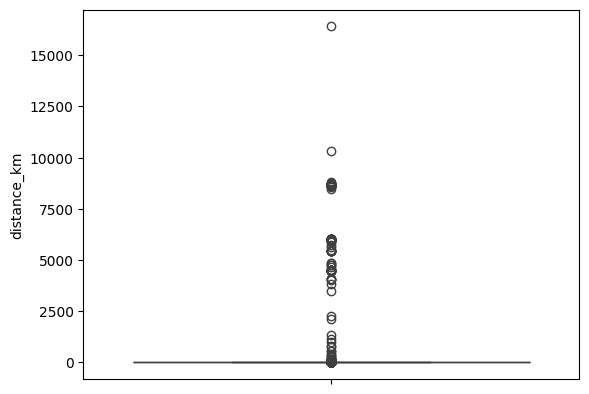

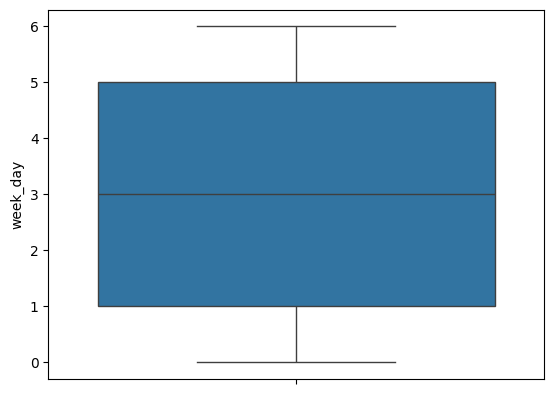

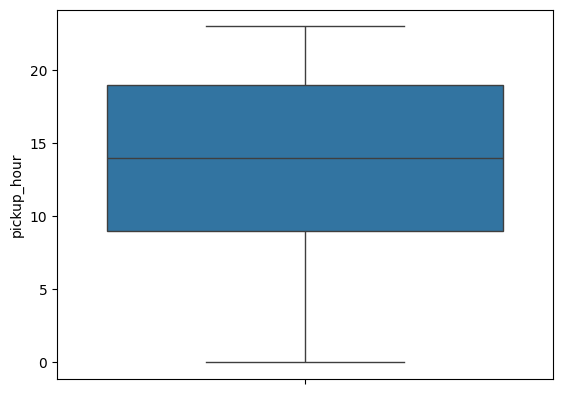

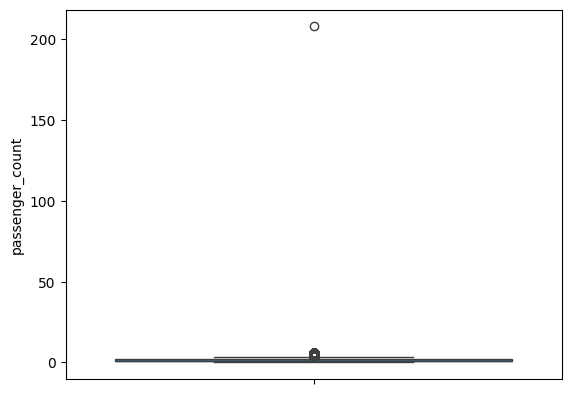

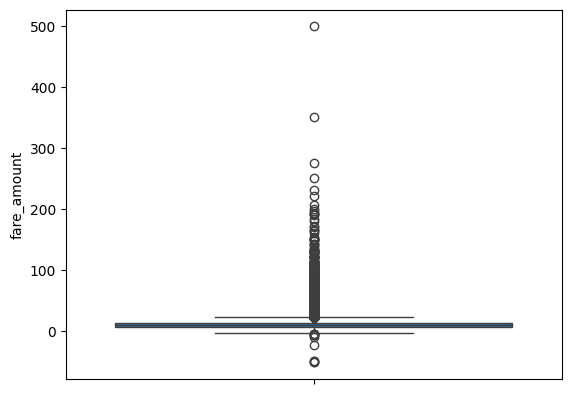

In [143]:
cols = df_selected.columns
for col in cols:
  sns.boxplot(df_selected[col])
  plt.show()

In [144]:
df_selected.describe()

,distance_km,week_day,pickup_hour,passenger_count,fare_amount
count,199948.000000,199948.000000,199948.000000,199948.000000,199948.000000
mean,20.860701,3.048478,13.491228,1.684568,11.358959
std,383.013932,1.946944,6.515471,1.386026,9.896936
min,0.000000,0.000000,0.000000,0.000000,-52.000000
25%,1.220000,1.000000,9.000000,1.000000,6.000000
50%,2.120000,3.000000,14.000000,1.000000,8.500000
75%,3.880000,5.000000,19.000000,2.000000,12.500000
max,16409.260000,6.000000,23.000000,208.000000,499.000000


In [145]:
def remove_outliers(data_frame, series_col):
 Q1 = np.percentile(series_col, 25)
 Q3 = np.percentile(series_col, 75)
 IQR = Q3 - Q1
 Lower_Limit = Q1 - 1.5 * IQR
 Upper_Limit = Q3 + 1.5 * IQR
 data_frame = data_frame[(series_col >Lower_Limit) & (series_col < Upper_Limit)]
 return data_frame

In [146]:
df_selected=remove_outliers(df_selected,df_selected['fare_amount'])
#df_selected=remove_outliers(df_selected,df_selected['distance_km'])
#df_selected=remove_outliers(df_selected,df_selected['passenger_count'])

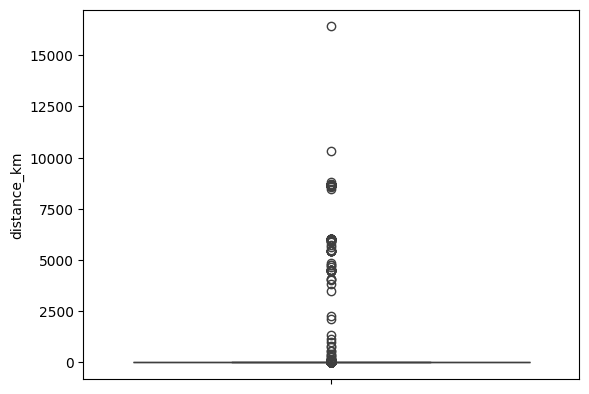

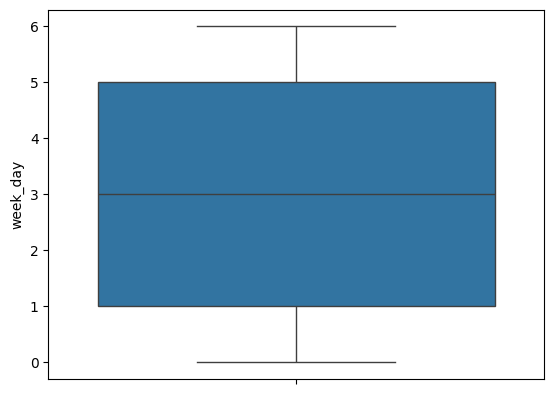

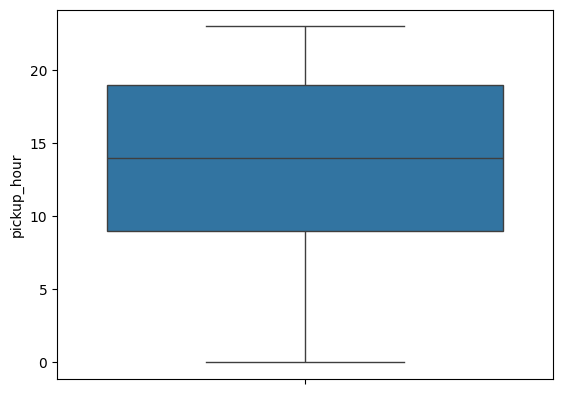

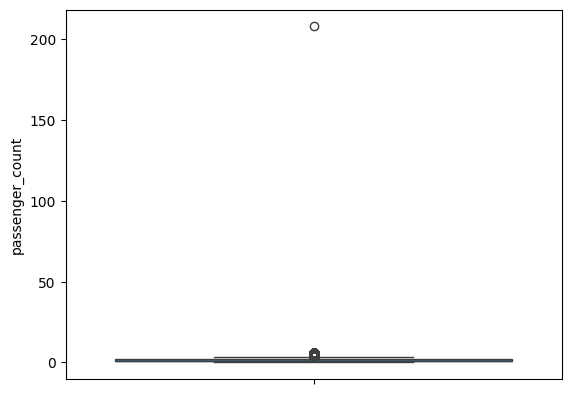

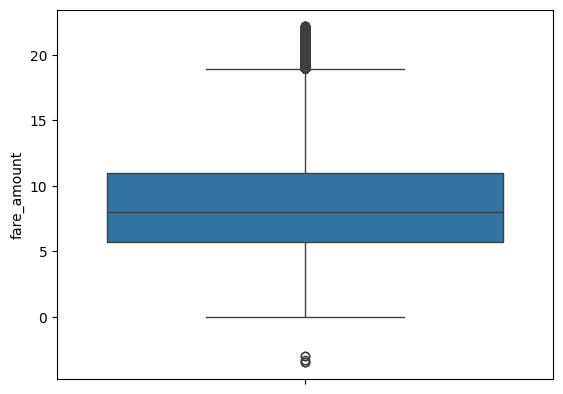

In [147]:
cols = df_selected.columns
for col in cols:
  sns.boxplot(df_selected[col])
  plt.show()

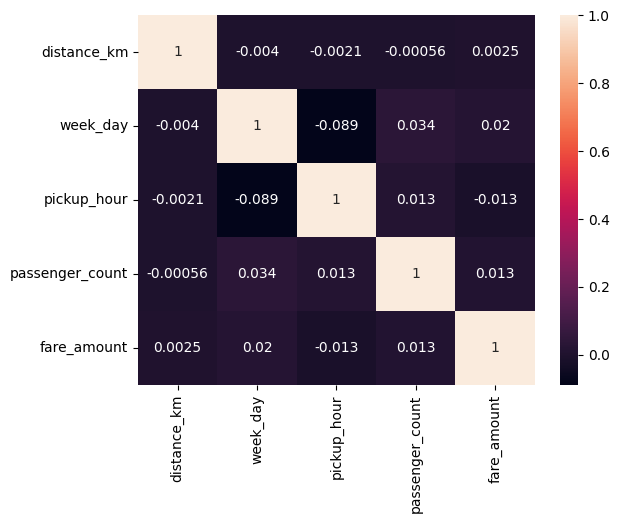

In [148]:
corr = df_selected.corr()
sns.heatmap(corr, annot=True)
plt.show()